<a href="https://colab.research.google.com/github/numthipka/CarDamageMaskRCNN/blob/master/mask_rcnn_damage_detection/TrainingModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Import Dependencues 

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!git clone https://github.com/numthipka/CarDamageMaskRCNN.git

In [ ]:
!pip uninstall tensorflow

In [ ]:
!pip install -r '/content/CarDamageMaskRCNN/mask_rcnn_damage_detection/requirements.txt'

In [16]:
import os
os.chdir('/content/CarDamageMaskRCNN/mask_rcnn_damage_detection')

In [17]:
# import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
#numthip add on 20200721 : in order to dont show the warning 
import warnings
warnings.filterwarnings("ignore")

import cv2
from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

# numthip add on 20200719 for img augmentation train
import imgaug as ia
from imgaug import augmenters as iaa

# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")
# ROOT_DIR = os.path.abspath("../")
# 20200627
ROOT_DIR = os.getcwd()

# 2 Constant

In [18]:
# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Cocmmand
DEFAULT_COMMAND = "train"
print("Command : ",DEFAULT_COMMAND)

# Weight
# 20200716 numthip k. comment ::>> DEFAULT_WEIGHT = "last"
DEFAULT_WEIGHT = "coco"
print("WEIGHT : ",DEFAULT_WEIGHT)

# Path to trained weights file
# COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
COCO_WEIGHTS_PATH = '/content/gdrive/My Drive/mask_rcnn/mask_rcnn_coco.h5'
print("Coco Weights Path : ",COCO_WEIGHTS_PATH)

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")
print("Log path : ", DEFAULT_LOGS_DIR)

# Directory of data
# DEFAULT_DATASET = os.path.join(os.getcwd(), "customImages")
DEFAULT_DATASET = '/content/gdrive/My Drive/mask_rcnn/customImages'
print("Dataset path : ", DEFAULT_DATASET)

# Path to trained weights file
# LAST_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
LAST_WEIGHTS_PATH = '/content/gdrive/My Drive/mask_rcnn/mask_rcnn_coco.h5'
# os.path.join(os.path.abspath("../logs/damage20200628T1311"), "mask_rcnn_damage_0010.h5")
#print("Last Weights Path : ",LAST_WEIGHTS_PATH)
 
    
# Numthip Add constnt epoch 
# number of epoch for training 
EPOCHS_CONST = 40


Command :  train
WEIGHT :  coco
Coco Weights Path :  /content/gdrive/My Drive/mask_rcnn/mask_rcnn_coco.h5
Log path :  /content/CarDamageMaskRCNN/mask_rcnn_damage_detection/logs
Dataset path :  /content/gdrive/My Drive/mask_rcnn/customImages


# 3 Configurations

In [19]:
class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "damage"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
#     IMAGES_PER_GPU = 2 Numthip
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + toy

    # Number of training steps per epoch 
    # 20200716 : numthip changes from 100  to 200 
    STEPS_PER_EPOCH = 600

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

# 4 Dataset

In [20]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("damage", 1, "damage")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        # dataset_dir = os.path.join(dataset_dir, subset)
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions'].values()]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "damage",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "damage":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "damage":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

# 5 Image augmentation 
only horizontol flip here

In [21]:
#2020719 - Numthip added  augmentationof the images set to be horizontal flip 
#augmentation = iaa.Sequential([
#    iaa.Fliplr(0.5) # only horizontal flip here
#])
augmentation = iaa.Sequential([
    iaa.OneOf([ ## rotate
        iaa.Affine(rotate=0),
        iaa.Affine(rotate=90),
    ]),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([ ## brightness or contrast
        iaa.Multiply((0.9, 1.1)),
        iaa.ContrastNormalization((0.9, 1.1)),
    ]),
    iaa.OneOf([ ## blur or sharpen
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
        iaa.Sharpen(alpha=(0.0, 0.1)),
    ]),
])


In [22]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(DEFAULT_DATASET, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(DEFAULT_DATASET, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
      # 20200716 : numthip changes from 100  to 200 
        #model.train(dataset_train, dataset_val,
        #       learning_rate=config.LEARNING_RATE,
        #      epochs=10,
        #     layers='heads')
        #,#augmentation=augmentation)
        
    ##Numthip Add : 20200726 
    ##add call back for mAP Cal as Link: "https://github.com/matterport/Mask_RCNN/issues/1839" 
    ##custom_callbacks
    
    # model_inference = modellib.MaskRCNN(mode="inference", config=config, model_dir=DEFAULT_LOGS_DIR)
    
    # mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model
    #                                                                         , model_inference
    #                                                                         , dataset_val
    #                                                                         , calculate_map_at_every_X_epoch=5
    #                                                                         , verbose=1)
        
    model.train(dataset_train, dataset_val,
             learning_rate=config.LEARNING_RATE,
             epochs=EPOCHS_CONST,
             layers='all',
             augmentation=augmentation)
             #,
             #custom_callbacks=[mean_average_precision_callback])
  

In [23]:
def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash

# 6 Training

In [24]:
if __name__ == '__main__':

    # Configurations
    if DEFAULT_COMMAND == "train":
        config = CustomConfig()
    else:
        class InferenceConfig(CustomConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if DEFAULT_COMMAND == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)

    # Select weights file to load
    if DEFAULT_WEIGHT.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif DEFAULT_WEIGHT.lower() == "last":
        # Find last trained weights
        weights_path = LAST_WEIGHTS_PATH
    elif DEFAULT_WEIGHT.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = DEFAULT_WEIGHT

    # Load weights
    print("Loading weights ", weights_path)
    if DEFAULT_WEIGHT.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train
    train(model)
    
    history = model.keras_model.history.history


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        400
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES 

# 7 Evaluate Model Loss and Val Loss

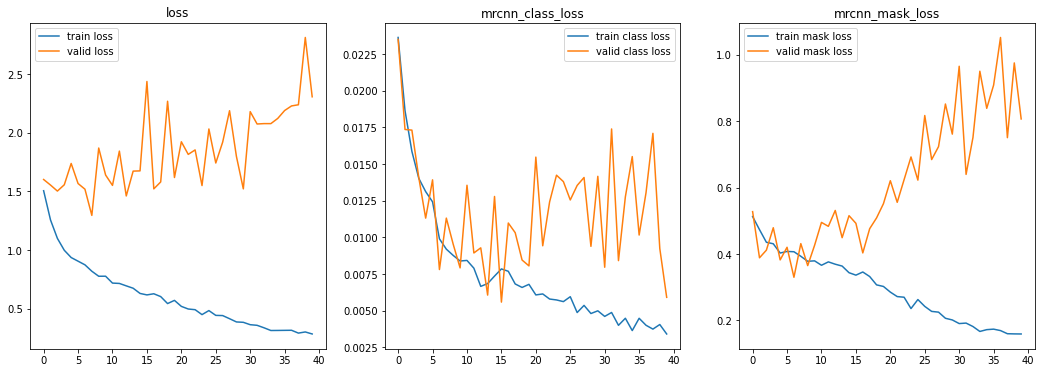

Best epoch:  8
Valid loss:  1.2959247195720673
Best Epoch: 8 1.2959247195720673


In [25]:
# numthip add chart train loss and valid loss 

epochs = range(EPOCHS_CONST)

plt.figure(figsize=(18, 6))

plt.subplot(131)
plt.title('loss')
plt.plot(epochs, history['loss'], label="train loss")
plt.plot(epochs, history['val_loss'], label="valid loss")
plt.legend()
plt.subplot(132)
plt.title('mrcnn_class_loss')
plt.plot(epochs, history['mrcnn_class_loss'], label="train class loss")
plt.plot(epochs, history['val_mrcnn_class_loss'], label="valid class loss")
plt.legend()
plt.subplot(133)
plt.title('mrcnn_mask_loss')
plt.plot(epochs, history['mrcnn_mask_loss'], label="train mask loss")
plt.plot(epochs, history['val_mrcnn_mask_loss'], label="valid mask loss")
plt.legend()

plt.show()

best_epoch = np.argmin(history["val_loss"]) + 1
print("Best epoch: ", best_epoch)
print("Valid loss: ", history["val_loss"][best_epoch-1])

best_epoch2 = np.argmin(history["val_loss"])
print("Best Epoch:", best_epoch2 + 1, history["val_loss"][best_epoch2])


In [26]:
# numthip add to print  train loss and valid loss 
#epochs = range(1,len(next(iter(history.values())))+1)
#pd.DataFrame(history, index=epochs)